#  Introduction to Classification: The Perceptron


In this lecture, we'll study one of the oldest machine learning algorithms: the perceptron. Invented in 1943 but not actually implemented in hardware until 1958, the perceptron is still relevant today as a fundamental building-block of modern deep neural networks. Indeed, one of the implementations of neural networks in `scikit-learn` is still called the "[multilayer perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)." 

When first announced, the perceptron algorithm also displayed one of the first examples of [AI Hype®](https://criticalai.org/the-ai-hype-wall-of-shame/). The *New York Times* uncritically repeated claims by a Navy rep that the perceptron algorithm would be the "embryo" of a computer that would "walk, talk, see, write, reproduce itself, and be conscious of its existence." As we study and implement the perceptron, you may wish to reflect on what you are doing and decide for yourself whether you believe that you are building the "embryo" of any such capabilities yourself.






::: {.column-margin}
![A headline from the New York Times: "New Navy Device Learns By Doing: Psychologist Shows Embryo of Computer Designed to Read and Grow Wiser."](../assets/img/perceptron-nyt.jpeg){#fig-nyt}
Early AI Hype. 
:::


### Our Data

The perceptron algorithm aims to find a rule for separating two distinct groups in some data. Here's an example of some data on which we might aim to apply the perceptron: 

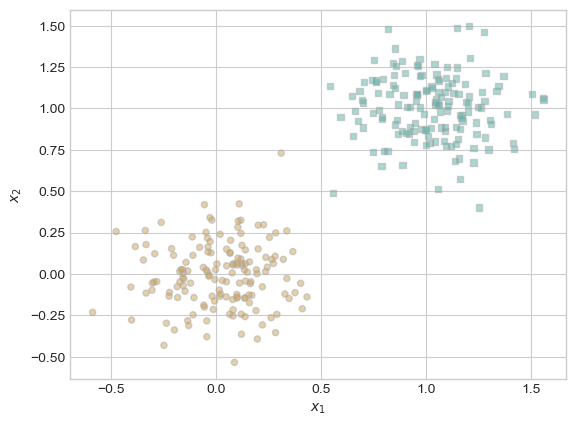

In [3]:
#| fig-cap: "300 data points in the 2d plane, each of which has one of two labels."
#| fig-cap-location: margin
#| label: fig-scatter
#| code-fold: true

import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(1234)

def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y

X, y = perceptron_data(n_points = 300, noise = 0.2)

def plot_perceptron_data(X, y, ax):
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = perceptron_data()
plot_perceptron_data(X, y, ax)

There are $n = 300$ points of data. Each data point $i$ has three pieces of information associated with it: 

- A *feature* $x_{i1}$. Think of a feature as a number you can measure, like a someone's height or interest in studying machine learning on a scale. 
- A second feature $x_{i2}$. We often collect all the features associated with a data point $i$ into a *feature vector* $\mathbf{x}_i$. In this case, $\mathbf{x}_i = (x_{i1}, x_{i2}) \in \mathbb{R}^2$.  We often further collect all the feature vectors into a *feature matrix* $\mathbf{X}$, by stacking all the feature vectors on top of each other: 
$$
\mathbf{X} = \left[\begin{matrix} & - & \mathbf{x}_1 & - \\ 
& - & \mathbf{x}_2 & - \\ 
& \vdots & \vdots & \vdots \\ 
& - & \mathbf{x}_{n} & - \end{matrix}\right]
$$
- A *target variable* $y_i$. In this data set, the target variable is has components equal to either $-1$ or $1$. [In many applications we assume that the target variable has values in $\{0, 1\}$. For the perceptron, it turns out to be extra convenient to use $\{-1, 1\}$ instead.]{.aside} You can think of it as representing a piece of yes-no information like whether a student is a computer science major or not. The target variables can be collected into a *target vector* $\mathbf{y} = (y_1, \ldots, y_{n})^T \in \{-1,1\}^{n}$. 

More generally, supervised prediction problems with $n$ data points and $k$ features can be summarized in terms of a *feature matrix* $\mathbf{X} \in \mathbb{R}^{n \times p}$ and a *target vector* $\mathbf{y} \in \mathbb{R}^n$.

### Linear Classifiers

The idea of a linear classifier is that we seek a *hyperplane* that approximately divides the data into its two classes. A hyperplane in $\mathbb{R}^p$ is an *affine subspace of dimension $\mathbb{R}^{p-1}$*. Such a hyperplane can be specified as the set of vectors $\mathbf{x} \in \mathbb{R}^p$ satisfying the equation 

$$
\langle \mathbf{w}, \mathbf{x}\rangle - b = \sum_{i = 1}^p w_i x_i - b = 0
$$ {#eq-hyperplane-1}

for some vector of *weights* $\mathbf{w} \in \mathbb{R}^p$ and *bias* $b \in R$. For mathematical convenience, it's nicer to write this equation as 

$$
\langle \tilde{\mathbf{w}}, \tilde{\mathbf{x}}\rangle = 0\;,
$$ {#eq-hyperplane}

where we have defined the new feature vectors $\tilde{\mathbf{x}} = (\mathbf{x}, 1)$ and $\tilde{\mathbf{w}} = (\mathbf{w}, -b)$. 

::: {.callout-note}

Throughout the remainder of these notes, we will assume that $\mathbf{x}$ has constant final feature value equal to 1. We'll therefore just write $\tilde{\mathbf{x}}$ and $\tilde{\mathbf{w}}$ instead of $\mathbf{x}$ and $\mathbf{w}$. 

:::


When $k = 2$, a hyperplane is just a line. Here are two candidate hyperplanes that we could use to classify our data. Which one looks like it better separates the two classes? 


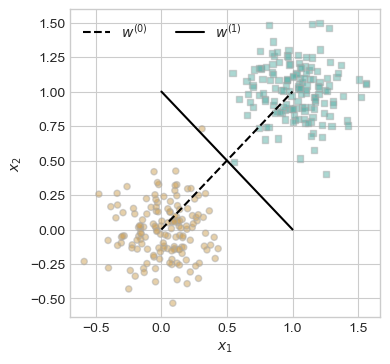

In [4]:
#| fig-cap: Two candidate separating hyperplanes for our data. Which one would you choose? 
#| fig-cap-location: margin
#| label: fig-scatter-with-separators
#| code-fold: true

def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_perceptron_data(X, y, ax)

w_0 = torch.Tensor([1, -1, 0])
w_1 = torch.Tensor([1,  1, -1]) 

draw_line(w_0, 0, 1, ax, color = "black", linestyle = "dashed", label = r"$w^{(0)}$")
draw_line(w_1, 0, 1, ax, color = "black", label = r"$w^{(1)}$")

l = ax.legend(ncol = 2)

Whereas the weight vector $\mathbf{w}^{(0)}$ generates a hyperplane that has data points from both classes on either side of it, the vector $\mathbf{w}^{(1)}$ *exactly separates* the two classes. What does it mean to exactly separate the two classes? It means that: 

$$
\langle \mathbf{w}^{(1)}, \mathbf{x}_i\rangle > 0 \Leftrightarrow y_i = 1\;. 
$$ {#eq-perceptron-predict}

That is, if someone gave you the weight vector $\mathbf{w}^{(1)}$, ***you wouldn't need to see the data labels***: you could exactly recover them using @eq-perceptron-predict. 

Let's make this a little more precise. For fixed $\mathbf{w}$, let $s_i \triangleq \langle \mathbf{w}, \mathbf{x}_i \rangle$ by the score. The classification *accuracy* of the two-label perceptron with weight $\mathbf{w}$is 

[We've used a little math trick here: take a moment to convince yourself that @eq-perceptron-predict is equivalent to the statement that $s_i y_i > 0$.]{.aside}

$$A(\mathbf{w}) \triangleq \frac{1}{n} \sum_{i = 1}^n \mathbb{1}[s_i y_i > 0]\;.$$

Higher accuracy means that the vector $\mathbf{w}$ predicts more correct labels via @eq-perceptron-predict. The *loss* (also called the *empirical risk*) is  

$$
R(\mathbf{w}) \triangleq 1 - A(\mathbf{w})\;.
$$ {#eq-loss}

It's customary in machine learning to work with the loss. Since we want the accuracy to be high, we want the loss to be small. In other words, we want to *minimize* the function $R$ with respect to the weight vector $\mathbf{w}$. This means that we want: 

$$
\DeclareMathOperator*{\argmin}{\arg\!\min\;}
\mathbf{w} = \argmin_{\mathbf{w}'} R(\mathbf{w}')
$${#eq-empirical-risk-minimization}

@eq-empirical-risk-minimization is our first example of the framework called *empirical risk minimization*, in which we define an *empirical risk* on the data and then seek a parameter vector that minimizes it. 

### The Perceptron Algorithm

The perceptron algorithm aims to find a good choice of $\mathbf{w}$ that makes the loss small using the following algorithm: 

1. Start with a *random* $\mathbf{w}^{(0)}$. 
2. "Until we're done," in each time-step $t$, 
    - Pick a random data point $i \in \{1,\ldots,n\}$. 
    - Compute $s^{(t)}_i = \langle \mathbf{w}^{(t)}, \mathbf{x}_i \rangle$. 
    - If $s^{(t)}_i y_i > 0$, then point $i$ is currently correctly classified -- do nothing! 
    - Else, if $s^{(t)}_i y_i < 0$, then perform the update 
    $$\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} + y_i \mathbf{x}_i\;.$$ {#eq-perceptron-update}

#### Example 

Now let's go ahead and run the perceptron algorithm on some data. First we should set up our feature matrix $\mathbf{X}$ and target vector $\mathbf{y}$. 

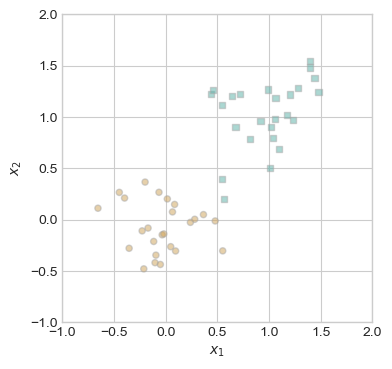

In [5]:
torch.manual_seed(1234)
X, y = perceptron_data(n_points = 50, noise = 0.3)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)

You may be able to eyeball the fact that this data is *linearly separable*: it is possible to draw a line that perfectly separates the two clusters. We can think of the perceptron algorithm as searching for such a line.

Let's start with a random guess for the weight vector $\mathbf{w}$:

In [6]:
#---
w = torch.Tensor([1, 1, 1])
#---

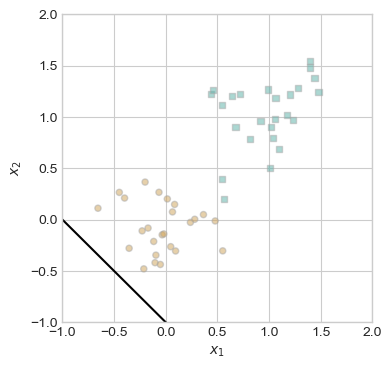

In [7]:
#| code-fold: true
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)
draw_line(w, -1, 2, ax, color = "black")

Well, that doesn't seem very promising. So, let's do the perceptron update! First, we need to pick a random data point: 

In [8]:
#| echo: false
torch.manual_seed(12)

In [9]:
#---
n = X.shape[0] # number of data points
i = torch.randint(n, size = (1,)) # index of a random data point
x_i = X[[i],] # the random data point itself
#---

Now we need to compute the score: 

In [10]:
#---
s_i = x_i@w
#---

We need to compare the score to the value of the target $y_i$:

In [11]:
#---
y_i = y[i]
s_i, y_i
#---

(tensor([1.1401]), tensor([-1]))

In this case, the score and the target have opposite signs, which means that we need to perform the perceptron update: 

In [12]:
#---
w = w + y_i*x_i
#---

If we now check the decision boundary again, it appears visually that it has improved slightly: 

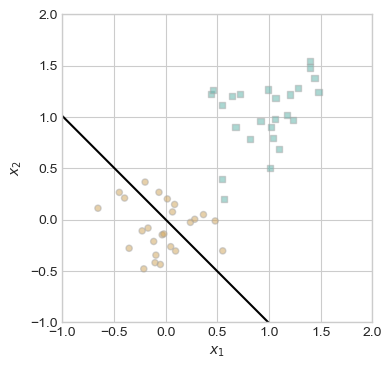

In [13]:
#| code-fold: true
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)
draw_line(w, -1, 2, ax, color = "black")

### A Minimal Training Loop 

Now it's time for us to introduce a *training loop*. In the training loop, we simply repeat the above procedure for a specified number of times (or until convergence). We're going to illustrate this using a specific *organization* of our computational steps, which will stick with us throughout most of the rest of these notes. 

[The classes `Perceptron` and `PerceptronOptimizer` are defined in an external script. You'll have the opportunity to implement and experiment with these classes in an upcoming assignment. ]{.aside}

In [17]:
from hidden.perceptron import Perceptron, PerceptronOptimizer

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)


We can track the progress of our training by checking the values of the loss function over time: 

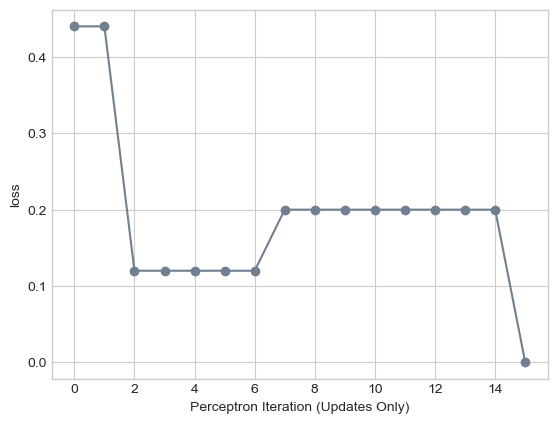

In [18]:
#| code-fold: false
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

We can see that training completed with the achievement of zero loss; that is, perfect training accuracy. 

## Illustration

The following figure illustrates the perceptron algorithm in action over several iterations. 

In [12]:
#| echo: false
from hidden.perceptron import Perceptron, PerceptronOptimizer

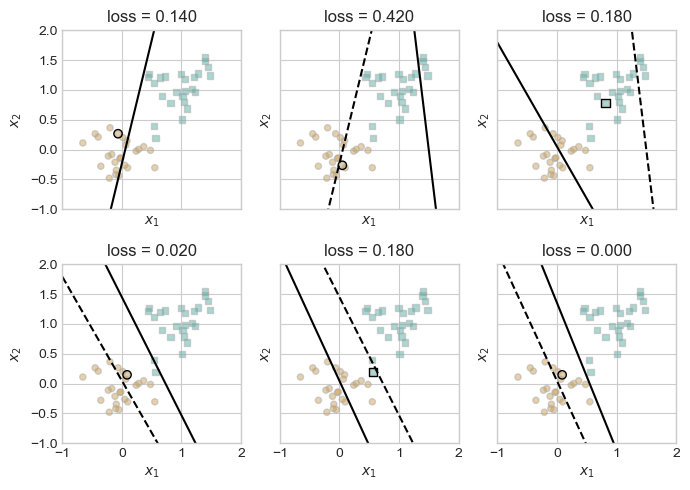

In [13]:
#| code-fold: true
#| fig-cap-location: margin
#| fig-cap: Several iterations of the perceptron algorithm. In each panel, the dashed line is the hyperplane corresponding to the previous weight vector $\mathbf{w}^{(t)}$, while the solid line is the hyperplane for the updated weight vector $\mathbf{w}^{t+1}$. The empty circle is the point $i$ used in the update; only iterations in which $i$ was a mistake are shown. The loss is computed as in @eq-loss. 
#| label: fig-demonstration

torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []

while loss > 0:
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 
    i, local_loss = opt.step(X, y)

    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if local_loss > 0:
        plot_perceptron_data(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[y[i].item()]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1
plt.tight_layout()

## Theory of the Perceptron Algorithm

Does the perceptron algorithm always improve our accuracy? Is it guaranteed to terminate? If it does terminate, is the result guaranteed to be a weight vector $\mathbf{w}$ that perfectly separates the two data classes? 

### Local Improvement on Data Point $i$

Let's first check that the perceptron update in @eq-perceptron-update actually improves the prediction on data point $i$ if there is currently a mistake on that point (i.e. if $s^{(t)}_i y_i < 0$). We can do this by computing the new $s_i^{(t+1)}$. Remember, what we want is for the sign of $s_i^{(t+1)}$ to match $y_i$. 

$$
\begin{align}
s_i^{(t+1)} &= \langle \mathbf{w}^{(t+1)}, \mathbf{x}_i\rangle  &\text{(definition of $s_i^{(t+1)}$)}\\ 
               &= \langle \mathbf{w}^{(t)} + y_i\mathbf{x}_i, \mathbf{x}_i\rangle &\text{(perceptron update)} \\ 
               &= \langle \mathbf{w}^{(t)},\mathbf{x}_i\rangle + y_i\langle \mathbf{x}_i, \mathbf{x}_i\rangle &\text{(linearity of $\langle \cdot\rangle$)}\\ 
               &= s_i^{(t)} + y_i \lVert \mathbf{x}_i\rVert_2^2\;. &\text{(definition of $s_i^{(t)}$ and $\lVert \mathbf{x}_i\rVert$)} 
\end{align}
$$

[Again, this is only if $s^{(t)}_i y_i < 0$; otherwise there is no change in $s_i^{(t)}$ in the current iteration.]{.aside}
Since $\lVert\mathbf{x}_i\rVert > 0$, we conclude that $s_i$ always moves in the right direction: if $y_i = 1$ then $s_i^{(t+1)} > s_i^{(t)}$, while if $y_i = -1$ then $s_i^{(t+1)} < s_i^{(t)}$. 

### Global Properties


::: {.callout-note}
::: {#def-linear-separability }

## Linear Separability

A data set with feature matrix $\mathbf{X} \in \mathbb{R}^{n\times k}$ and target vector $y\in \{-1, 1\}$ is *linearly separable* if there exists a weight vector $\mathbf{w}$ such that, for all $i \in [n]$, 

$$
\langle\mathbf{w}, \mathbf{x}_i\rangle > 0 \Leftrightarrow y = 1\;. 
$$

:::
:::

Take a moment to convince yourself of the following: 

::: {.callout-tip} 
::: {#prp-nonconvergence}

## Nonconvergence of perceptron for nonseparable data

Suppose that $(\mathbf{X}, \mathbf{y})$ is not linearly separable. Then, the perceptron update does not converge. Furthermore, at no iteration of the algorithm is it the case that $A(\mathbf{w}) = 1$. 

:::
:::

It's not as obvious that, if the data *is* linearly separable, then the perceptron algorithm will converge to a correct answer. Perhaps surprisingly, this is also true: 

::: {.callout-tip} 
::: {#thm-perceptron-convergence}

## Convergence of perceptron for separable data

Suppose that $(\mathbf{X}, \mathbf{y})$ is linearly separable. Then: 

- The perceptron algorithm converges in a finite number of iterations to a vector $\mathbf{w}$ that separates the data, so that $A(\mathbf{w}) = 1$.  
- During the running of the perceptron algorithm, the total number of updates made is no more than
$$\frac{2 + r(\mathbf{X})^2}{\gamma(\mathbf{X}, \mathbf{y})}\;,$$

where $r(\mathbf{X}) = \max_{i \in [n]} \lVert \mathbf{x}_i \rVert$ and $\gamma(\mathbf{X}, \mathbf{y})$ is a geometric measure called the *margin* of how far apart the two label classes are. 

:::
:::

For a proof of @thm-perceptron-convergence, see p. 37-44 of @hardtPatternsPredictionsActions2022.  

## What Next? 

We have outlined the perceptron algorithm, which is able to find a separating hyperplane between two labeled groups of points when such a hyperplane exists. 

We should, however, be troubled by the fact that the perceptron algorithm doesn't converge when the data isn't linearly separable. Maybe we could design a different algorithm that would allow us to find a parameter vector $\mathbf{w}$ that makes the empirical risk $R(\mathbf{w}) = 1 - A(\mathbf{w})$ as small as possible? 

Unfortunately, we have a grave problem here: 

::: {.callout-tip} 

::: {#thm-perceptron-np-hard}

## 0-1 Minimization for Linear Classifiers is NP Hard (@kearnsEfficientAgnosticLearning1992)

Unless P = NP, there is no polynomial-time algorithm that can find a $\mathbf{w}$ that solves @eq-empirical-risk-minimization when $R(\mathbf{w}) = 1 - A(\mathbf{w})$ is the rate of incorrect classifications. 

:::
:::

So, if our data is not linearly separable, not only will the perceptron algorithm not converge, but *no* classical algorithm will solve the minimization problem in polynomial time. 

In order to make progress towards practical algorithms, we will need to slightly change our approach. This will be the subject of our next several chapters. 


## References